# gBizINFO API データ品質検証

このノートブックでは、経済産業省が提供するgBizINFO APIの**データ品質**を検証します。
具体的に以下の点を明らかにします：

1. **時間的整合性**: 公開日と実際のデータ更新日の乖離
2. **網羅性**: 全省庁のデータが適切に統合されているか
3. **年次分布**: 各年のデータ量の偏り（2015-2025年）
4. **欠損値**: 重要フィールドの欠損率

## 前提条件
- APIキーを取得済み
- Python 3.9以上
- 必要ライブラリ: pandas, numpy, matplotlib, requests

## 分析者
Rioto3 (@Rioto3)

In [4]:
# APIトークンを直接指定（セキュリティに注意）
API_TOKEN = "YOUR_API_TOKEN"
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"

BASE_URL = "https://info.gbiz.go.jp/hojin"

# リクエストヘッダー
HEADERS = {
    'X-hojinInfo-api-token': API_TOKEN
}

# 記録開始年の調査
このスクリプトは：
1. 2025年から開始
2. 各カテゴリで1件でもデータがあるか確認
3. データがある限り前の年に進む
4. 0件になった年の次の年を返す

# 年ごとの件数の分布を取得

今後調査をして行く上で、年ごとの偏りを調査しておく。

各年一様に分布していることを期待する。

In [19]:
import requests
import pandas as pd
from datetime import datetime
import setting

def get_yearly_update_count(start_year=2015, end_year=datetime.now().year):
    results = {}
    
    for year in range(start_year, end_year + 1):
        from_date = f"{year}0101"
        to_date = f"{year}1231"
        
        # 各情報カテゴリごとにリクエスト
        categories = [
            'updateInfo', 
            'updateInfo/certification', 
            'updateInfo/commendation', 
            'updateInfo/finance', 
            'updateInfo/patent', 
            'updateInfo/procurement', 
            'updateInfo/subsidy', 
            'updateInfo/workplace'
        ]
        
        total_count = 0
        for category in categories:
            url = f"{setting.BASE_URL}/v1/hojin/{category}"
            
            params = {
                'from': from_date,
                'to': to_date,
                'page': 1,
                'limit': 1
            }
            
            try:
                response = requests.get(
                    url, 
                    headers=setting.HEADERS, 
                    params=params
                )
                
                if response.status_code == 200:
                    data = response.json()
                    total_count += int(data.get('totalCount', 0))
                
            except Exception as e:
                print(f"Error fetching data for {year} - {category}: {e}")
        
        results[year] = total_count
    
    return results

# 年次データ数を取得
yearly_counts = get_yearly_update_count()

# データフレームに変換して表示
df = pd.DataFrame.from_dict(yearly_counts, orient='index', columns=['更新件数'])
df.index.name = '年'
print(df)


         更新件数
年            
2015  1891027
2016   151265
2017   135216
2018   585810
2019   498252
2020  1134076
2021   666341
2022   582689
2023   786179
2024  5349999
2025   395262


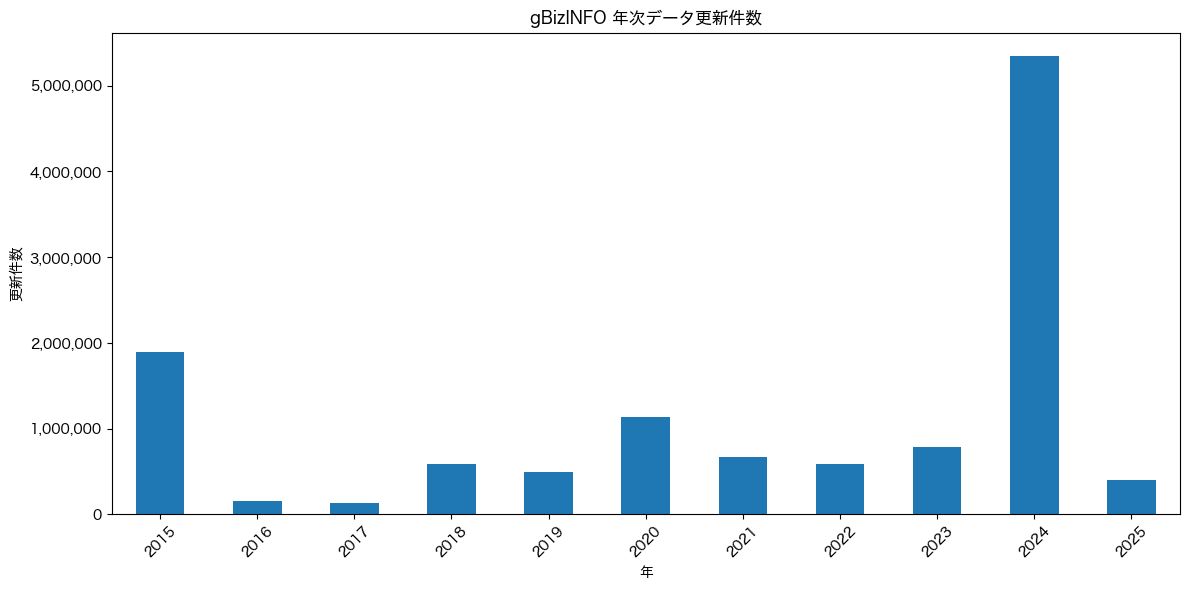

In [28]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter

# ヒラギノ角ゴシック W3 フォントを指定
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# y軸の目盛りを見やすくするための設定
def format_yaxis(x, pos):
    # xはy軸の値、posは位置
    return '{:,.0f}'.format(x)  # カンマ区切りで整数にフォーマット

# グラフ作成
plt.figure(figsize=(12, 6))
df['更新件数'].plot(kind='bar')
plt.title('gBizINFO 年次データ更新件数')
plt.xlabel('年')
plt.ylabel('更新件数')

# y軸の目盛りにカスタムフォーマッターを適用
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 考察

年ごとの件数に、明らかに偏りがある。
2024年は最大の530万件の更新があったが、例えば2016年は15万件程度と10%程である。

周期性が見えないが、少なくとも、年を跨ぐ調査においては影響が出ることが考えられる。
